In [1]:
import numpy as np
from pathlib import Path
from pyminflux.analysis import find_cutoff_near_value, get_robust_threshold, prepare_histogram
from pyminflux.reader import MinFluxReader
from pyminflux.processor import MinFluxProcessor
from pyminflux.correct import drift_correction_time_windows_2d
from pyminflux.fourier import estimate_resolution_by_frc
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

# Example processing

The complete pyMINFLUX API can be found on https://pyminflux.ethz.ch/api.

## Open a file and inspect data

In [2]:
# Open a file
reader = MinFluxReader("2D_FA-IIF-AF467_crop.npy")
reader

File: 2D_FA-IIF-AF467_crop.npy: 2D normal acquisition with 78460 entries (all valid).

In [3]:
# Set a processor on the reader
processor = MinFluxProcessor(reader, min_trace_length=4)  # Drop short-lived traces

In [4]:
# Have a look at the data
processor.filtered_dataframe.head()

,tid,tim,x,y,z,efo,cfr,eco,dcr,dwell,fluo
0,87,2.352604,6446.844851,-3990.753281,0.0,84021.005251,0.624847,168,0.646067,2.0,1
1,87,2.359186,6438.524442,-4004.899799,0.0,98524.631158,0.491394,197,0.555556,2.0,1
2,87,2.365768,6436.041289,-4002.683427,0.0,84021.005251,0.422516,168,0.595506,2.0,1
3,87,2.372350,6441.751471,-4003.722791,0.0,79353.171626,0.535156,238,0.660079,3.0,1
4,87,2.381117,6442.907035,-4006.524754,0.0,94023.505876,0.419495,188,0.606061,2.0,1


In [5]:
# Is this a 3D dataset?
processor.is_3d

False

## Estimate resolution by Fourier Ring Correlation

We use the per-trace ID mean localizations to estimate the resolution.

In [6]:
# Run the resolution estimation on per-trace localization data
resolution, qi, ci, resolutions, cis = estimate_resolution_by_frc(
    x=processor.filtered_dataframe_stats["mx"].values,
    y=processor.filtered_dataframe_stats["my"].values,
    rx=None, ry=None, num_reps=5, seed=2023, return_all=True
)

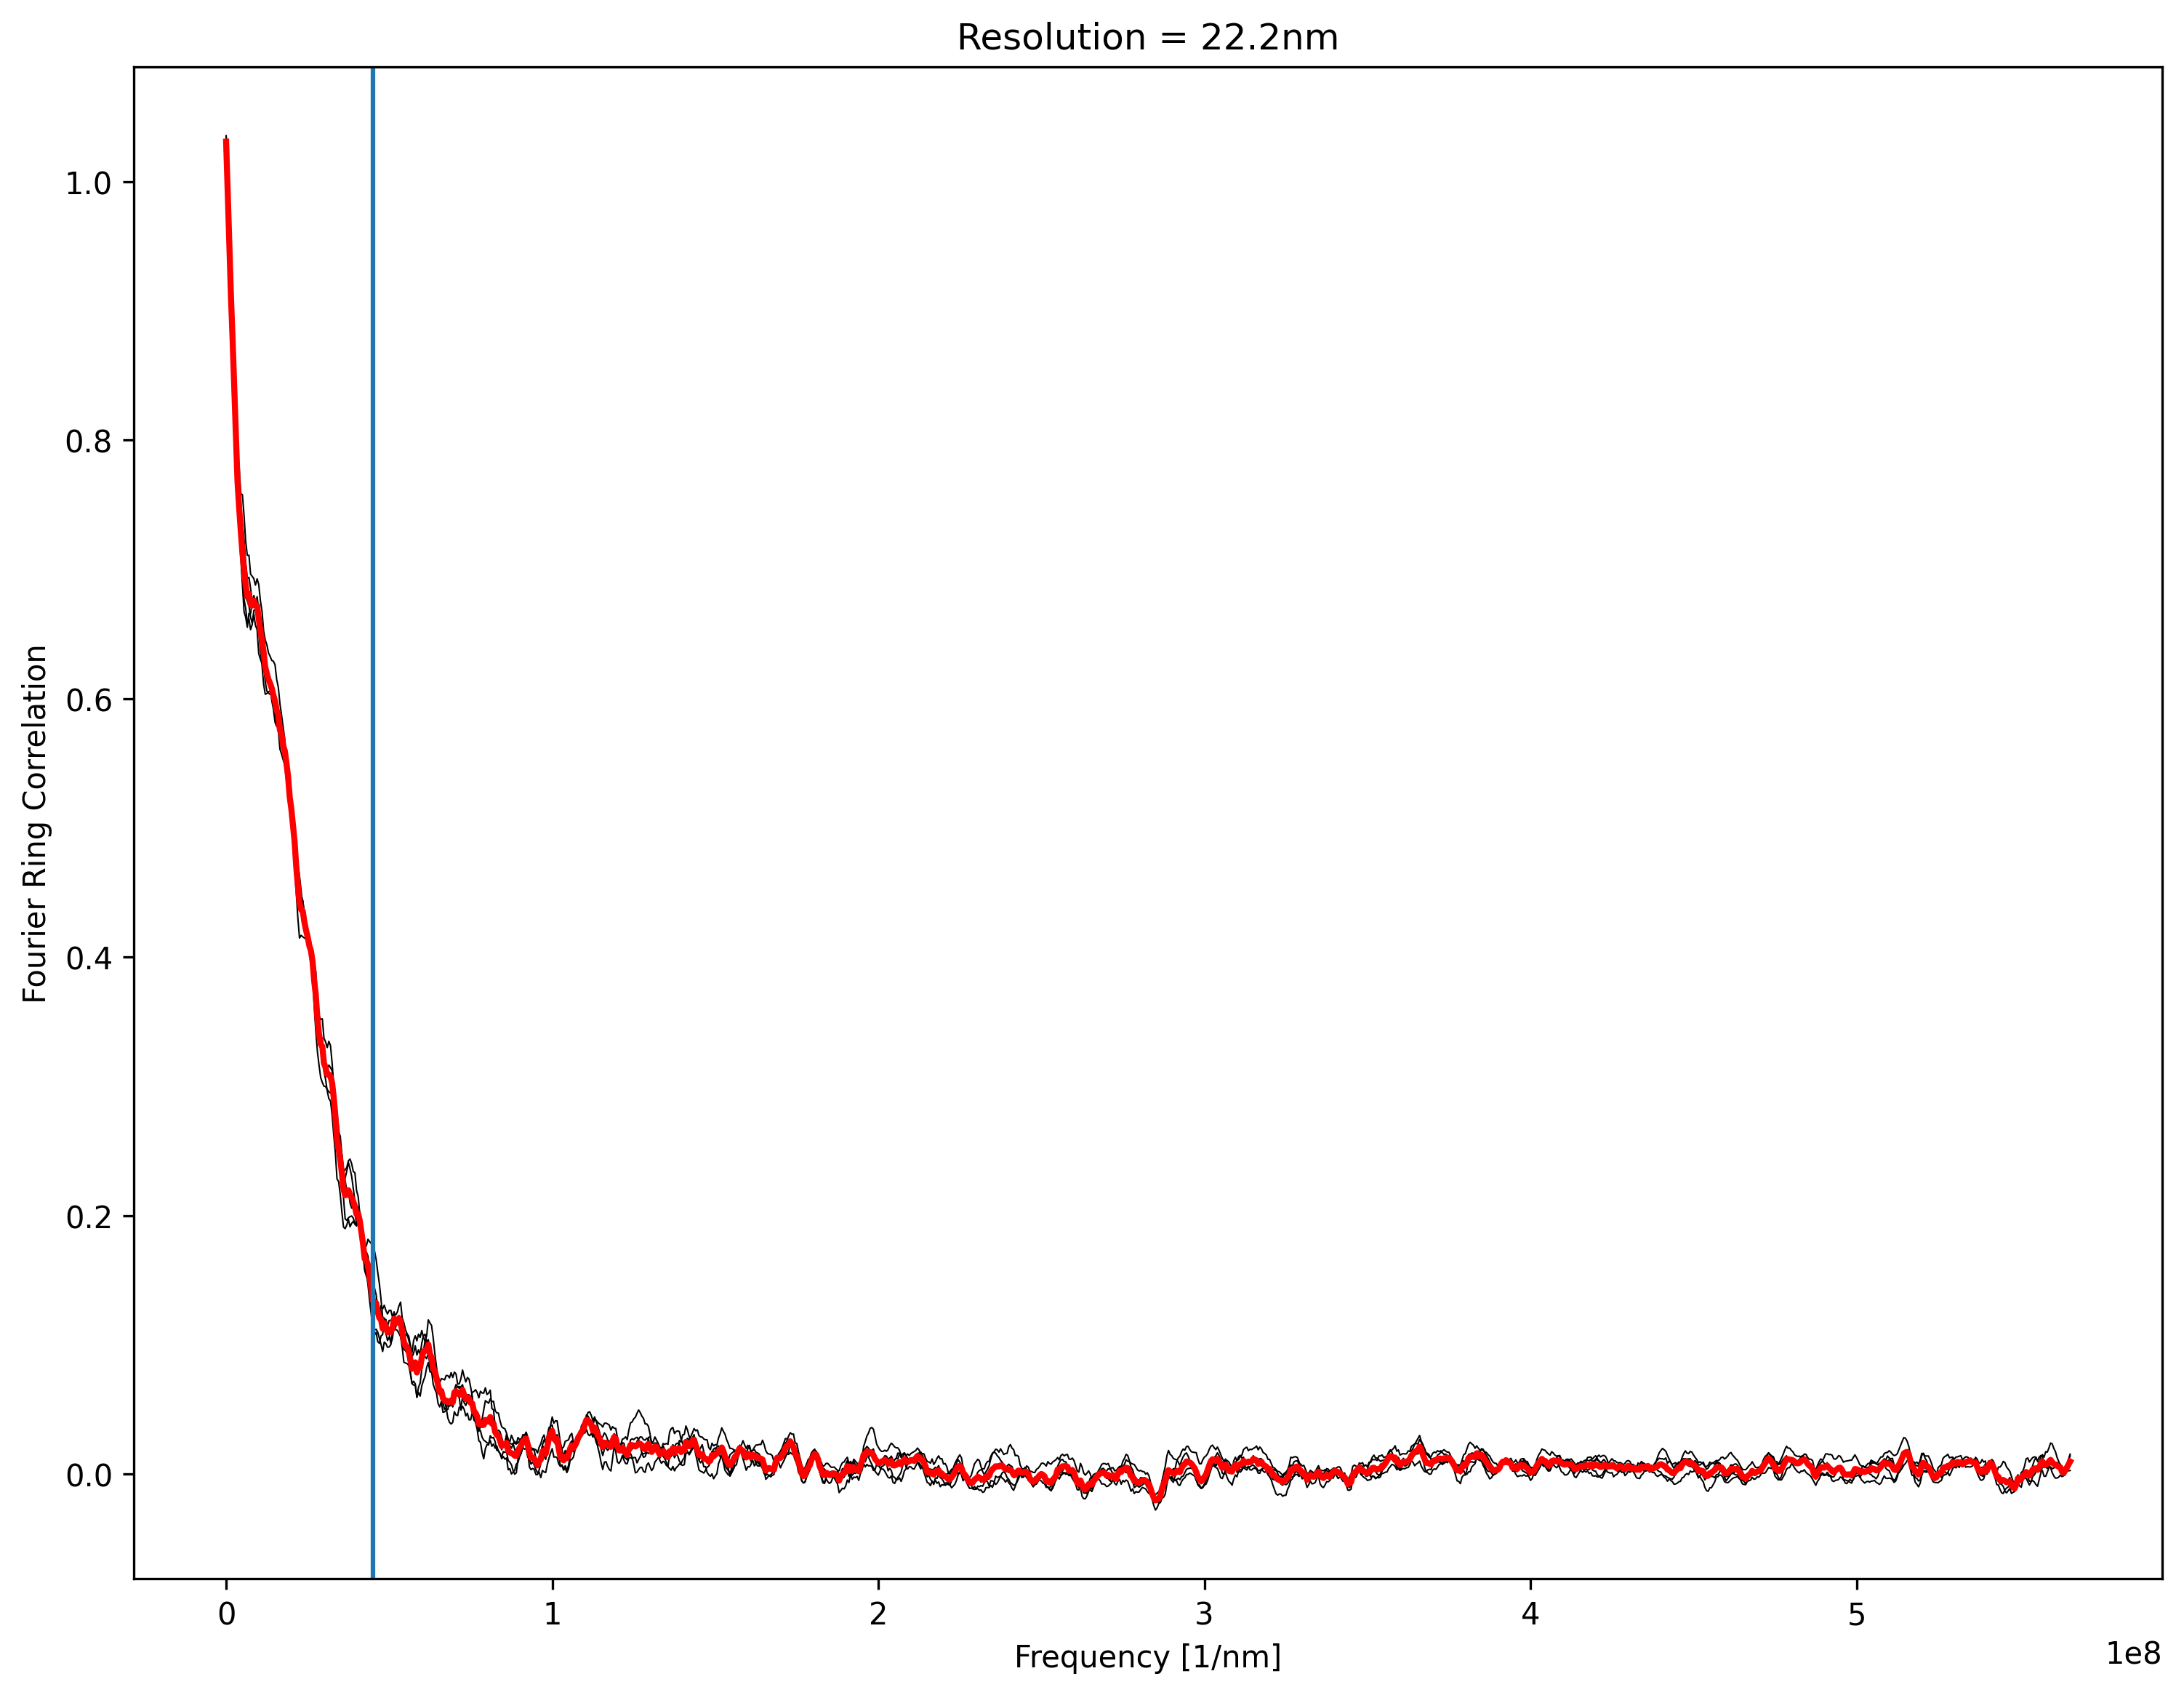

In [7]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)

# Plot individual cis in black and width = 0.75
for i in range(cis.shape[1]):
    ax.plot(qi, cis[:, i], 'k-', linewidth=0.5)
ax.plot(qi, ci, 'r-', linewidth=2)
ax.axvline(x=1.0 / resolution)
ax.set_xlabel("Frequency [1/nm]")
ax.set_ylabel("Fourier Ring Correlation")
ax.set_title(f"Resolution = {1e9 * resolution:.1f}nm");

### Simulate resolution progression throughout acquisition

In [8]:
temporal_resolution = 1800 # s
t_start = processor.filtered_dataframe["tim"].min()
t_end = processor.filtered_dataframe["tim"].max()
n_steps = int(np.round((t_end - t_start) / temporal_resolution))
t_steps = np.linspace(t_start, t_end, n_steps)
t_steps = t_steps[1:]

In [9]:
rx = (processor.filtered_dataframe["x"].min(), processor.filtered_dataframe["x"].max())
ry = (processor.filtered_dataframe["y"].min(), processor.filtered_dataframe["y"].max())

#### Using per-trace (average) localizations

In [10]:
trace_resolutions = []
for i, t in enumerate(t_steps):
    df = processor.select_by_1d_range("tim", x_range=(t_start, t))
    df_gr = df.groupby("tid")
    mx = df_gr["x"].mean()
    my = df_gr["y"].mean()
    resolution, _, _ = estimate_resolution_by_frc(
        x=mx, y=my, sx=4.0, sy=4.0, rx=rx, ry=ry, num_reps=5, seed=2023, return_all=False
    )
    trace_resolutions.append(1e9 * resolution)
    print(f"{len(mx)} traces: {i + 1}/{len(t_steps)}")

210 traces: 1/39
364 traces: 2/39
454 traces: 3/39
523 traces: 4/39
594 traces: 5/39
679 traces: 6/39
759 traces: 7/39
846 traces: 8/39
907 traces: 9/39
982 traces: 10/39
1049 traces: 11/39
1119 traces: 12/39
1172 traces: 13/39
1237 traces: 14/39
1305 traces: 15/39
1361 traces: 16/39
1416 traces: 17/39
1456 traces: 18/39
1520 traces: 19/39
1578 traces: 20/39
1653 traces: 21/39
1699 traces: 22/39
1743 traces: 23/39
1817 traces: 24/39
1885 traces: 25/39
1957 traces: 26/39
2034 traces: 27/39
2118 traces: 28/39
2200 traces: 29/39
2283 traces: 30/39
2360 traces: 31/39
2448 traces: 32/39
2530 traces: 33/39
2619 traces: 34/39
2712 traces: 35/39
2806 traces: 36/39
2899 traces: 37/39
3000 traces: 38/39
3094 traces: 39/39


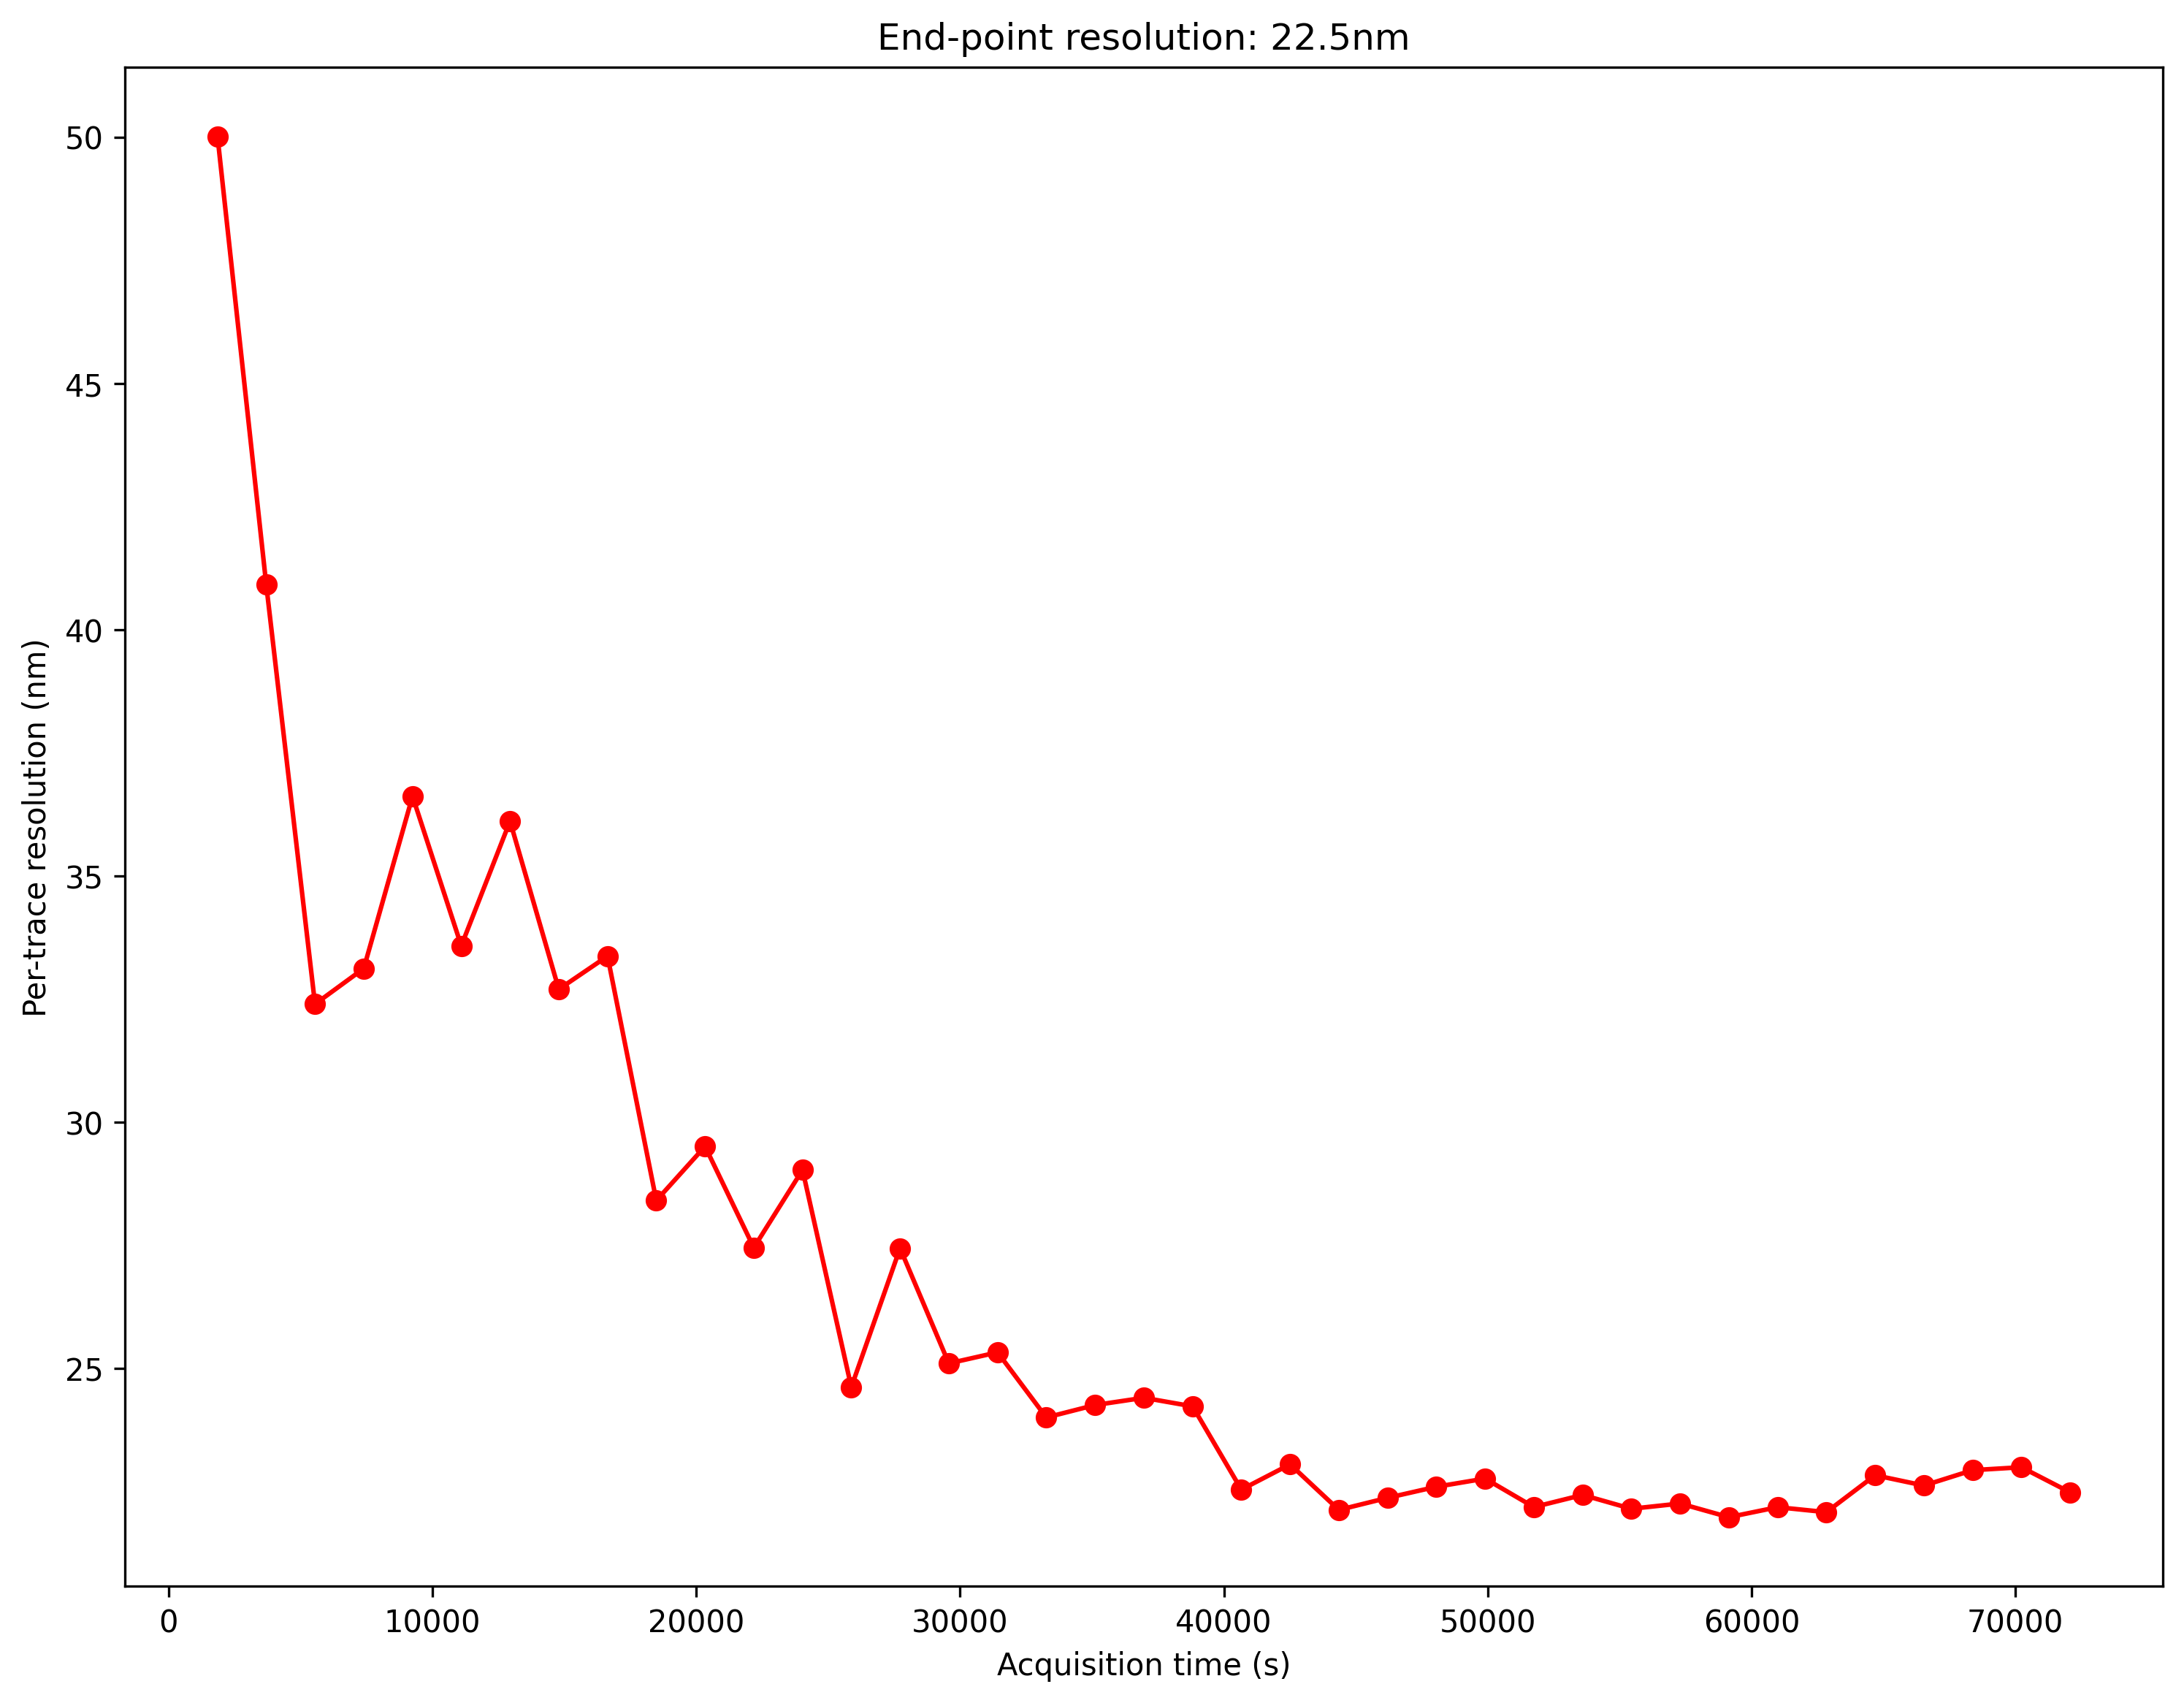

In [11]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)
ax.plot(t_steps, trace_resolutions, 'r-o')
ax.set_xlabel("Acquisition time (s)")
ax.set_ylabel("Per-trace resolution (nm)");
ax.set_title(f"End-point resolution: {trace_resolutions[-1]:.1f}nm");

## Apply EFO and CFR filters

In [12]:
# Calculate cutoff for EFO

single_emitter_frequency = 25000   # For this acquisition we expect the peak for single emitters to be at 25kHz

n_efo, _, b_efo, _ = prepare_histogram(
    processor.filtered_dataframe["efo"].values,
    auto_bins=False,
    bin_size=1000.0,   # For EFO, we usually bin at 1kHz
)
cutoff_frequency = find_cutoff_near_value(
    counts=n_efo,
    bins=b_efo,
    expected_value=2.0 * single_emitter_frequency   
)
print(cutoff_frequency)

49000.0


In [13]:
# Calculate robust threshold for CFR
upper_thresh, _, _, _ = get_robust_threshold(
    processor.filtered_dataframe["cfr"].values, factor=2.0
)
print(upper_thresh)

0.8365654683162231


In [14]:
# Apply EFO filter (limits already estimated from the UI)
processor.filter_by_1d_range("efo", x_range=(0.0, cutoff_frequency))
processor.filter_by_1d_range("cfr", x_range=(0.0, upper_thresh))

In [15]:
# Re-calculate resolution
resolution, qi, ci, resolutions, cis = estimate_resolution_by_frc(
    x=processor.filtered_dataframe_stats["mx"].values,
    y=processor.filtered_dataframe_stats["my"].values,
    rx=rx, ry=ry, num_reps=5, seed=2023, return_all=True
)

## Estimate updated resolution by Fourier Ring Correlation after EFO and CFR filtering

In [16]:
# Run the resolution estimation on per-trace localization data
resolution, qi, ci, resolutions, cis = estimate_resolution_by_frc(
    x=processor.filtered_dataframe_stats["mx"].values,
    y=processor.filtered_dataframe_stats["my"].values,
    rx=None, ry=None, num_reps=5, seed=2023, return_all=True
)

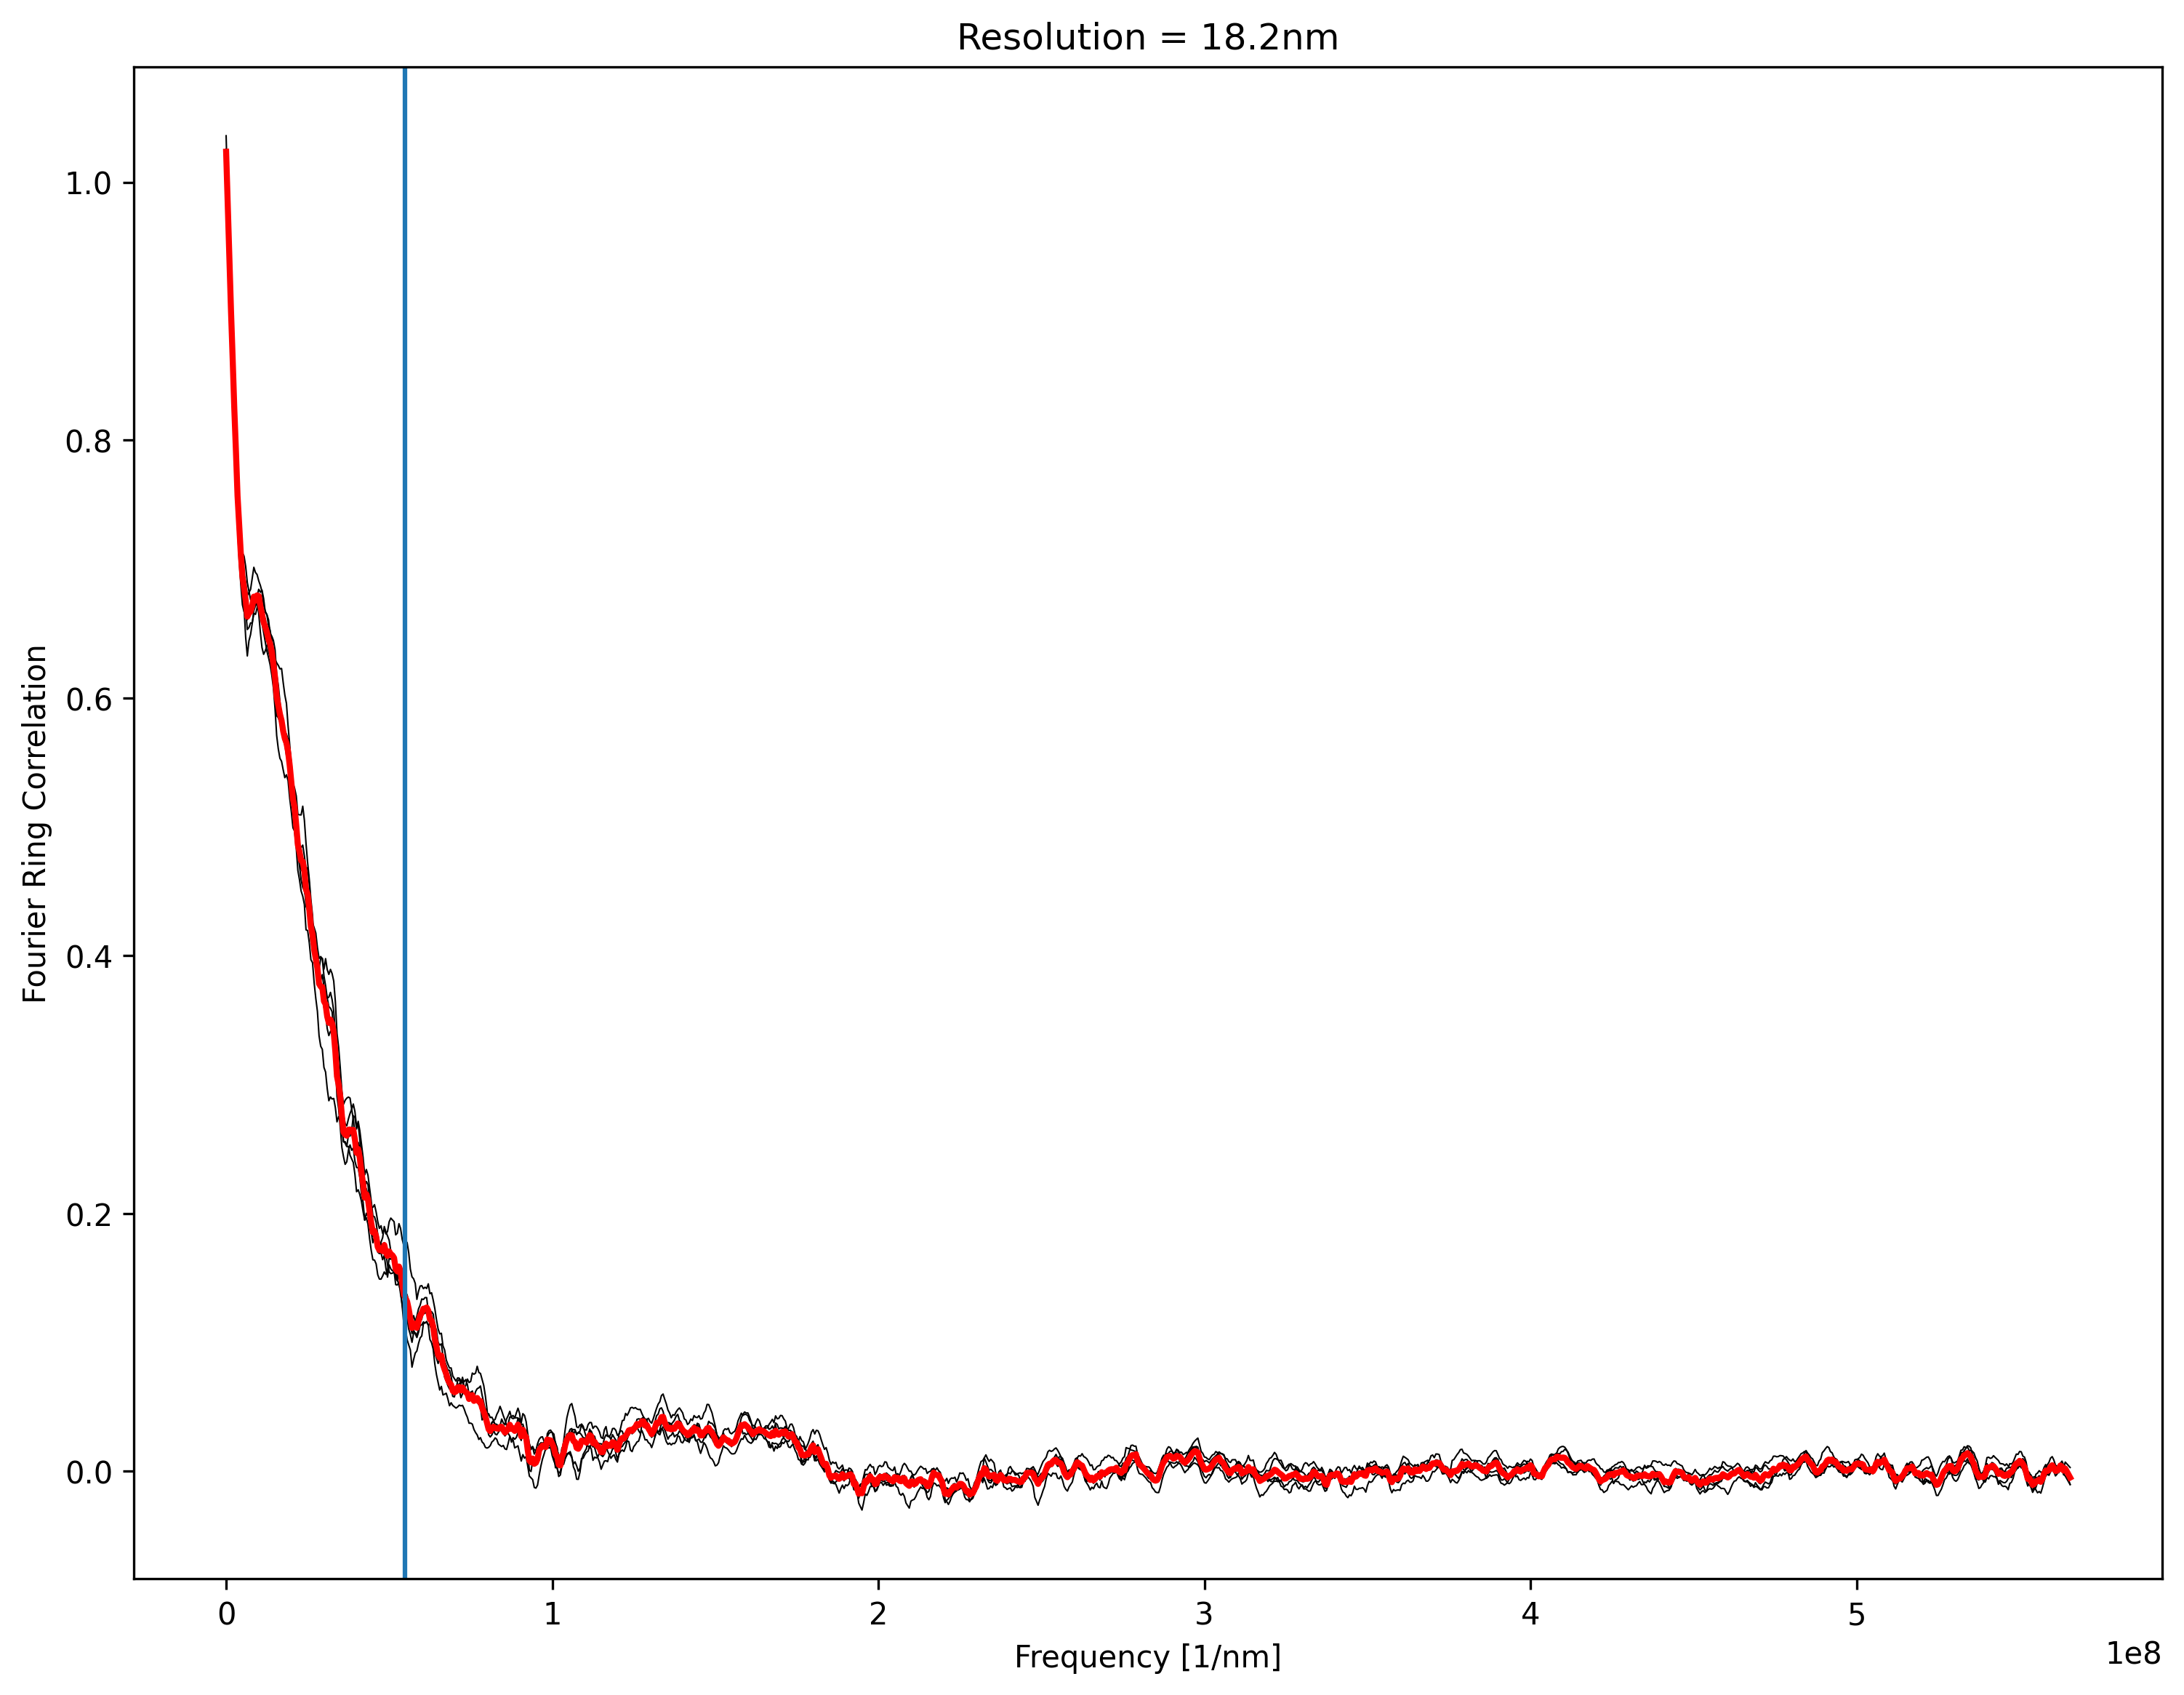

In [17]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)

# Plot individual cis in black and width = 0.75
for i in range(cis.shape[1]):
    ax.plot(qi, cis[:, i], 'k-', linewidth=0.5)
ax.plot(qi, ci, 'r-', linewidth=2)
ax.axvline(x=1.0 / resolution)
ax.set_xlabel("Frequency [1/nm]")
ax.set_ylabel("Fourier Ring Correlation")
ax.set_title(f"Resolution = {1e9 * resolution:.1f}nm");